In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 27.6 MB/s 
     |████████████████████████████████| 163 kB 57.9 MB/s 
     |████████████████████████████████| 7.6 MB 59.4 MB/s 


In [69]:
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from transformers import get_scheduler


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

In [244]:
strategyTable = pd.DataFrame(columns = ['ticker', 'strategy', 'annual_return', 'annual_vol', 'annual_sharpe',
                                        'cum_return', 'maxDD'])

In [ ]:
torch.cuda.is_available()

True

In [70]:
class simpleProcessor():
    
    def __init__(self, priceFile, newsFile, tickerName, priceType):
        self.tickerName = tickerName
        self.priceType = priceType
        self.news_data = pd.read_csv(newsFile, index_col = [0])
        self.price_vol = pd.read_csv(priceFile, index_col= [0])
        self.crypto_price = self.price_vol[[tickerName + '-' + priceType]].shift(1)
        self.crypto_news = self.news_data[[tickerName]]
        self.crypto_price.index = pd.to_datetime(self.crypto_price.index).tz_convert(None)
        self.crypto_news.index = pd.to_datetime(self.crypto_news.index)
        self.data = None
        
    def getData(self):
        data = self.crypto_news.merge(self.crypto_price, how = 'inner', left_index = True, right_index = True)
        data[self.tickerName + '_summary'] = data.apply(lambda x :self.joinStr(x), axis = 1)
        data['returns'] = data[self.tickerName + '-' + self.priceType].pct_change().shift(-1)
        data['class'] = data['returns'] > 0
        data = data.iloc[:-1, :]
        
        nonewsdate = data[data.isna().any(axis = 1)].index
        newsdate = data[~data.isna().any(axis = 1)].index
        
        self.data = data[~data.isna().any(axis = 1)][[self.tickerName + '_summary', 'class']]
        self.data.columns = ['text', 'class']
        self.data['class'] = self.data['class'].map({True : 1, False : 0})
        
        return self.data.copy(), data
        
    @staticmethod
    def joinStr(df):
        lists = eval(df[0])
        if(lists[0]):
            return ' '.join(lists[0])
        return np.nan

# Embedding + LSTM

In [26]:
class newsDataset(Dataset): 
    
    def __init__(self, df, tokenizer):
        self.labels = [i for i in df['class']]
        self.texts = [tokenizer(str(text), 
                                padding='max_length',
                                truncation = True, 
                                return_tensors='pt')
                      for text in df['text']]
        
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_text(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_text(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_texts, batch_labels

In [216]:
class embeddingClassifier(nn.Module):
    
    def __init__(self, pre_trained = 'bert-base-uncased', lstm_layers = 2, lr = 1e-3):
        super().__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.bert = BertModel.from_pretrained(pre_trained)
        self.bert.requires_grad_(False) #frozen parameters
        self.hidden_size = self.bert.config.hidden_size
        
        self.lstm_layers = lstm_layers
        self.LSTM = nn.LSTM(input_size=self.hidden_size, hidden_size=256, num_layers=lstm_layers, dropout = 0.2)
        
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(in_features=256, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        
        self.optimizer = Adam(self.parameters(), lr = lr)
        self.criterion = nn.BCELoss(reduction='sum')
        
    def forward(self, input_id, mask):
        h = torch.zeros((self.lstm_layers, input_id.size(0), 256)).to(self.device)
        c = torch.zeros((self.lstm_layers, input_id.size(0), 256)).to(self.device)
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)
        
        encoded_layers = self.bert(input_ids=input_id, attention_mask=mask)[0]
        encoded_layers = encoded_layers.permute(1, 0, 2)
        
        out, (hn, cn) = self.LSTM(encoded_layers, (h, c))
        out = out[-1, :, :].view(-1, 256)
        out = self.bn1(out)
        
        out = torch.relu_(self.fc1(out))
        out = self.bn2(out)

        out = torch.sigmoid(self.fc2(out))
        
        return out

In [34]:
def trainer(model, trainLoader, validLoader, epochs):
    #epochs 
    trainloss = []
    validloss = []
    
    model = model.to(model.device)
    print(model.device)
    for _ in trange(epochs):
        
        #set model to training model
        model.train()
        
        total_loss = 0
        total_num = 0
        for train_inputs, train_labels in trainLoader:
            
            train_labels = train_labels.float()
            train_labels = train_labels.to(model.device)
            mask = train_inputs['attention_mask'].to(model.device)
            input_id = train_inputs['input_ids'].squeeze(1).to(model.device) 
            
            
            model.optimizer.zero_grad()

            output = model(input_id, mask)

            loss = model.criterion(output, train_labels.unsqueeze(1))
            loss.backward()
                        
            model.optimizer.step()
            total_loss += loss.item()
            
            total_num += input_id.size(0)
        
        # Validation
        model.eval()
        
        total_loss_val = 0
        total_num_val = 0
        preds = []
        trues = []
        with torch.no_grad():
            
            for valid_inputs, valid_labels in validLoader:
                
                valid_labels = valid_labels.float()
                valid_labels = valid_labels.to(model.device)
                mask = valid_inputs['attention_mask'].to(model.device)
                input_id = valid_inputs['input_ids'].squeeze(1).to(model.device)
                
             
                output = model(input_id, mask)
                
                loss = model.criterion(output, valid_labels.unsqueeze(1))
                
                total_loss_val += loss.item()
                total_num_val += input_id.size(0)

                probs = output.detach().cpu().numpy()
                predictions = [1 if p > 0.5 else 0 for p in probs]
                
                labels = valid_labels.detach().cpu().numpy().flatten()
                
                
                preds += list(predictions)
                trues += list(labels)
        
        
        trainloss.append(total_loss/total_num)
        validloss.append(total_loss_val/total_num_val)
        print('\n\t - Train loss : {:.4f}'.format(total_loss / total_num))
        print('\t - Validation loss : {:.4f}'.format(total_loss_val / total_num_val))
        print('\t - Validation accuracy : {:.4f}'.format(accuracy_score(trues, preds)))
        print('\t - Validation precision : {:.4f}'.format(precision_score(trues, preds)))
        print('\t - Validation recall : {:.4f}'.format(recall_score(trues, preds)))
    
    return trainloss, validloss

In [56]:
def evaluate(model, testLoader):
    model = model.to(model.device)
    preds = []
    with torch.no_grad():
      for test_inputs, test_labels in testLoader:

        test_labels = test_labels.float()
        test_labels = test_labels.to(model.device)
        mask = test_inputs['attention_mask'].to(model.device)
        input_id = test_inputs['input_ids'].squeeze(1).to(model.device)

        output = model(input_id, mask)

        probs = output.detach().cpu().numpy()
        predictions = [1 if p > 0.5 else 0 for p in probs]

        preds += list(predictions)        
    
    return preds

In [295]:
ticker = 'ETH'
train_data1, data = simpleProcessor('/content/gdrive/MyDrive/Colab Notebooks/price_vol.csv', '/content/gdrive/MyDrive/Colab Notebooks/btc_eth.csv', ticker, 'close').getData()

In [296]:
percent = 0.8
n = train_data1.shape[0]
trainData, testData = train_data1.iloc[0 : int(n*percent)], train_data1.iloc[int(n*percent):]
m = trainData.shape[0]
trainData, validData = trainData.iloc[0 : int(m*percent)], trainData.iloc[int(m*percent): ]

In [297]:
backtest = testData
y_test = list(testData.iloc[:, 1])

In [298]:
BERT_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)
trainDataLoader = DataLoader(newsDataset(trainData, tokenizer), batch_size = 32, drop_last = True)
validDataLoader = DataLoader(newsDataset(validData, tokenizer), batch_size = 32, drop_last = True)
testDataLoader = DataLoader(newsDataset(testData, tokenizer), batch_size = 32)

In [299]:
num_epochs = 5
model = embeddingClassifier(lr = 1e-4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [300]:
trainloss, validloss = trainer(model, trainDataLoader, validDataLoader, num_epochs)

cuda


 20%|██        | 1/5 [01:42<06:49, 102.37s/it]


	 - Train loss : 0.7294
	 - Validation loss : 0.7072
	 - Validation accuracy : 0.4809
	 - Validation precision : 0.5064
	 - Validation recall : 0.5248


 40%|████      | 2/5 [03:24<05:07, 102.45s/it]


	 - Train loss : 0.6832
	 - Validation loss : 0.7175
	 - Validation accuracy : 0.4878
	 - Validation precision : 0.5121
	 - Validation recall : 0.5578


 60%|██████    | 3/5 [05:07<03:24, 102.45s/it]


	 - Train loss : 0.6720
	 - Validation loss : 0.7194
	 - Validation accuracy : 0.5000
	 - Validation precision : 0.5225
	 - Validation recall : 0.5743


 80%|████████  | 4/5 [06:49<01:42, 102.46s/it]


	 - Train loss : 0.6608
	 - Validation loss : 0.7171
	 - Validation accuracy : 0.5000
	 - Validation precision : 0.5235
	 - Validation recall : 0.5512


100%|██████████| 5/5 [08:32<00:00, 102.45s/it]


	 - Train loss : 0.6413
	 - Validation loss : 0.7523
	 - Validation accuracy : 0.4913
	 - Validation precision : 0.5184
	 - Validation recall : 0.4653


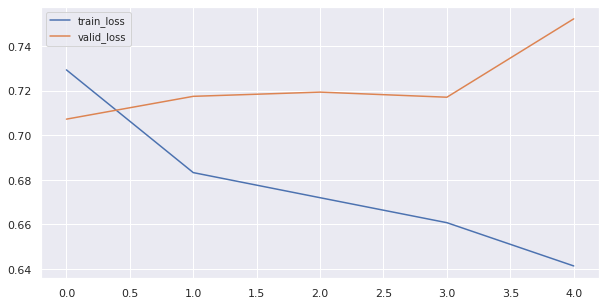

In [301]:
sns.set()
plt.figure(figsize=(10, 5))
plt.plot(trainloss, label='train_loss')
plt.plot(validloss, label='valid_loss')
plt.legend(fontsize=10)

In [302]:
model_save_name = '{}_model.pt'.format(ticker)
path = F"/content/gdrive/MyDrive/Colab Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)

In [303]:
y_test_pred = evaluate(model, testDataLoader)

# Evaluate

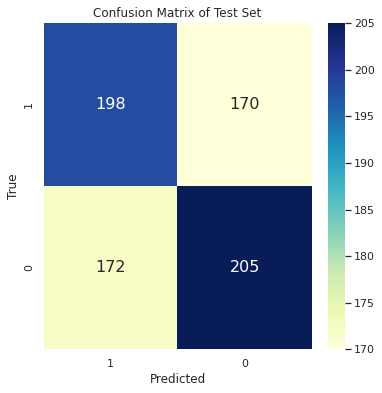

In [304]:
cm_test = confusion_matrix(y_test, y_test_pred, labels = [1, 0])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [305]:
print(classification_report(y_test, y_test_pred, labels = [1, 0]))

              precision    recall  f1-score   support

           1       0.54      0.54      0.54       368
           0       0.55      0.54      0.55       377

    accuracy                           0.54       745
   macro avg       0.54      0.54      0.54       745
weighted avg       0.54      0.54      0.54       745



# Simple Backtest


In [306]:
class backtestMetrics:
    
    def __init__(self, df):
        self.df = df
        self.df_dailyreturn = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        
    def get_return(self):
        return (np.power(self.df.iloc[-1,:]/self.df.iloc[0,:],365*24/self.N) - 1)[0]
    
    def get_vol(self):
        return (np.std(self.df_dailyreturn)*np.sqrt(365*24))[0]
    
    def get_sharpe(self):
        return (self.get_return()/self.get_vol())
    
    def get_cumReturn(self):
        return (self.df.iloc[-1,:]/self.df.iloc[0,:] - 1)[0]
    
    def get_maxdd(self):
        return ((np.maximum.accumulate(self.df) - self.df)/np.maximum.accumulate(self.df)).max()[0]
    
    def strategy_map(self, ticker, strategy_type):
        map1 = {'ticker': ticker,
        'strategy': strategy_type, 
        'annual_return': self.get_return(),
        'annual_vol': self.get_vol(),
        'annual_sharpe': self.get_sharpe(),
        'cum_return': self.get_cumReturn(),
        'maxDD': self.get_maxdd()}
        
        return map1

In [307]:
def simpleBacktest(backtest, y_pred_test, data):
    
    backtest['signal'] = y_pred_test
    backtest_start_date = backtest.index[0]
    
    allBacktest = data[data.index >= backtest_start_date][['returns']]
    backtestTable = allBacktest.merge(backtest[['signal']], how = 'left', left_index=True, right_index=True)
    backtestTable = backtestTable.fillna(method = 'ffill') # maintain viewpoints
    
    def simpleBacktest(df):
        if(df[1] == 1):
            return df[0]
        return 0.0
    
    backtestTable['realized_returns'] = backtestTable.apply(lambda x: simpleBacktest(x), axis = 1)
    backtestTable['strat_nav'] = (1 + backtestTable['realized_returns']).cumprod()
    backtestTable['nav'] = (1 + backtestTable['returns']).cumprod()
    
    return backtestTable

In [308]:
backtestTable = simpleBacktest(backtest, y_test_pred, data)
backtestTable_name = 'backtest_{}.csv'.format(ticker)
path = F"/content/gdrive/MyDrive/Colab Notebooks/{backtestTable_name}" 
backtestTable.to_csv(path)

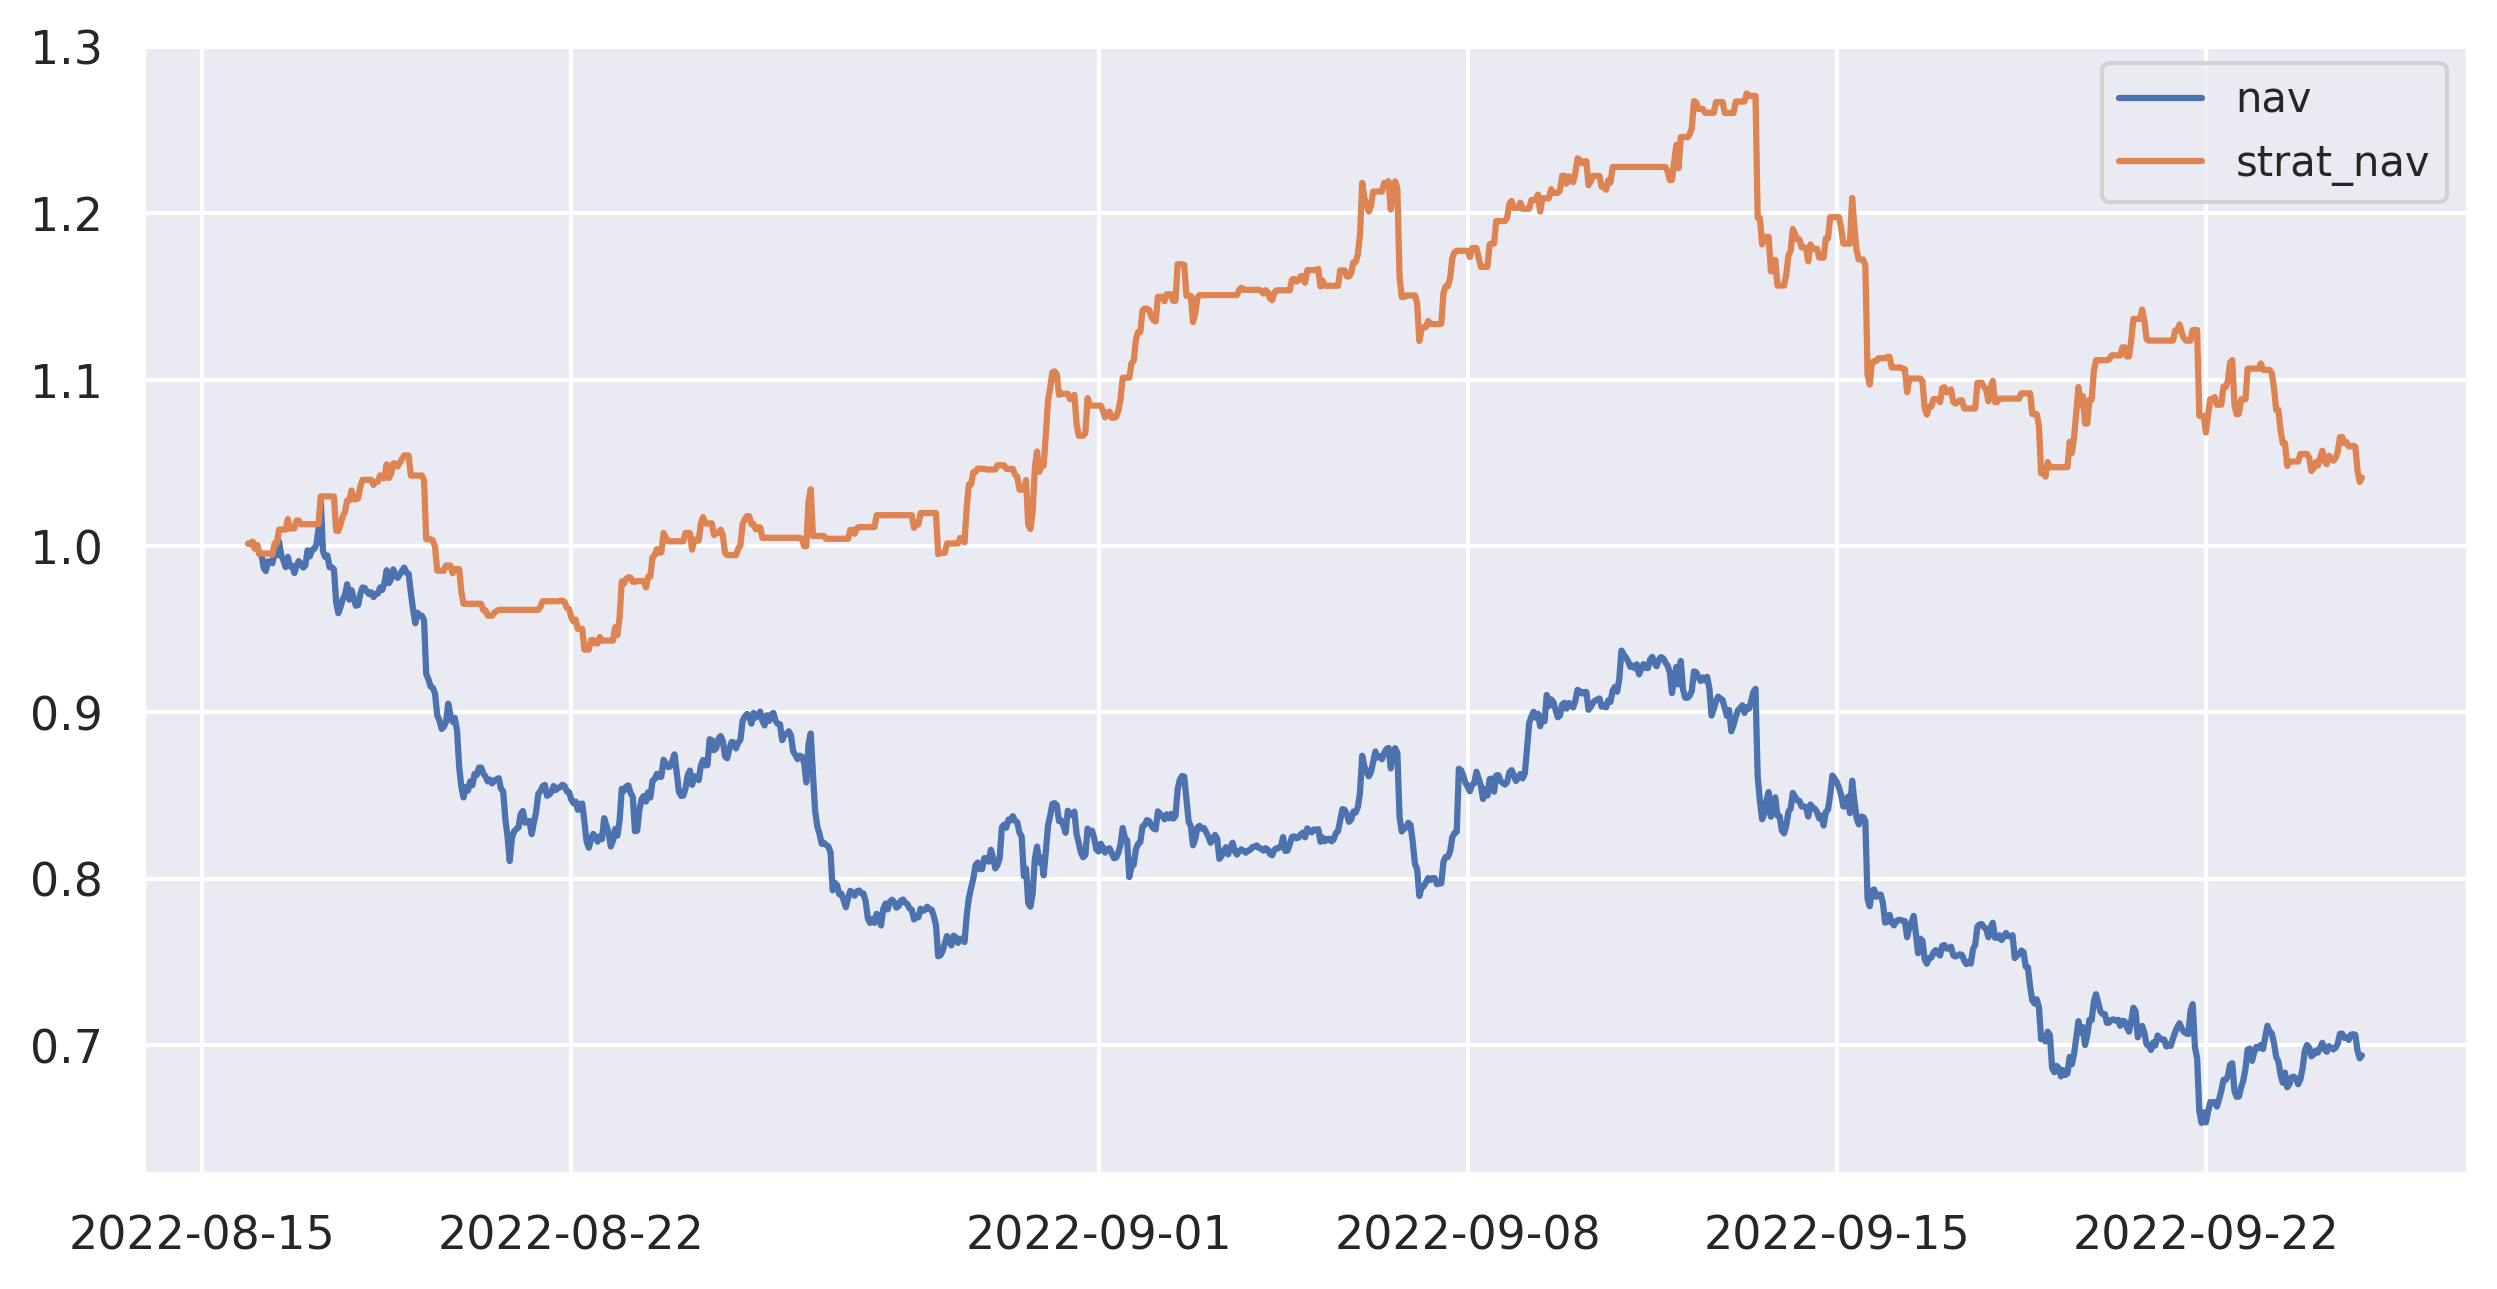

In [309]:
sns.set()
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(backtestTable['nav'], label='nav')
plt.plot(backtestTable['strat_nav'], label='strat_nav')
plt.legend(fontsize=10)

In [310]:
print("Simple Strategy")
strategyMetrics = backtestMetrics(backtestTable[['strat_nav']])
print("Annual Return : {}".format(strategyMetrics.get_return()))
print("Annual Vol : {}".format(strategyMetrics.get_vol()))
print("Annual Sharpe : {}".format(strategyMetrics.get_sharpe()))
print("Cumulative Return : {}".format(strategyMetrics.get_cumReturn()))
print("Annual Max DD : {}".format(strategyMetrics.get_maxdd()))

Simple Strategy
Annual Return : 0.4260932733414282
Annual Vol : 0.5872950983507035
Annual Sharpe : 0.7255181841939816
Cumulative Return : 0.039748057280563964
Annual Max DD : 0.18357963605552127


In [311]:
strategyTable = strategyTable.append(backtestMetrics(backtestTable[['strat_nav']]).strategy_map(ticker, 'simple_strategy'), ignore_index=True)

In [312]:
print("Buy and Hold")
strategyMetrics = backtestMetrics(backtestTable[['nav']])
print("Annual Return : {}".format(strategyMetrics.get_return()))
print("Annual Vol : {}".format(strategyMetrics.get_vol()))
print("Annual Sharpe : {}".format(strategyMetrics.get_sharpe()))
print("Cumulative Return : {}".format(strategyMetrics.get_cumReturn()))
print("Annual Max DD : {}".format(strategyMetrics.get_maxdd()))

Buy and Hold
Annual Return : -0.9646191393260984
Annual Vol : 0.7818992462368775
Annual Sharpe : -1.2336872608185963
Cumulative Return : -0.307165367640995
Annual Max DD : 0.3640397652583056


In [313]:
strategyTable = strategyTable.append(backtestMetrics(backtestTable[['nav']]).strategy_map(ticker, 'buy_and_hold'), ignore_index=True)

In [314]:
strategyTable

,ticker,strategy,annual_return,annual_vol,annual_sharpe,cum_return,maxDD
0,BNB,simple_strategy,-0.209633,0.358707,-0.584413,-0.033117,0.143503
1,BNB,buy_and_hold,-0.466757,0.555109,-0.840839,-0.086078,0.228866
2,BTC,simple_strategy,-0.626720,0.455452,-1.376039,-0.108905,0.160747
3,BTC,buy_and_hold,-0.895990,0.526264,-1.702547,-0.232658,0.259941
4,BTC,simple_strategy,0.572514,0.356940,1.603952,0.054395,0.083991
5,BTC,buy_and_hold,-0.895990,0.526264,-1.702547,-0.232658,0.259941
6,ETH,simple_strategy,0.426093,0.587295,0.725518,0.039748,0.183580
7,ETH,buy_and_hold,-0.964619,0.781899,-1.233687,-0.307165,0.364040


In [315]:
path = F"/content/gdrive/MyDrive/Colab Notebooks/strategyTable.csv" 
strategyTable.to_csv("strategyTable.csv")